<a href="https://colab.research.google.com/github/dccdoshi/Astrostats/blob/main/JointDiffusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Joint Diffusion

Here we will go over an example of joint diffusion sampling for a case of a galaxy convolved by a PSF. Drawing samples here corresponds to performing deconvolution, a classic problem in Astronomy.

In [ ]:
# Install experimental version of torch_score_models
!git clone https://github.com/ConnorStoneAstro/torch_score_models.git
%cd torch_score_models
!git checkout connor_jan
!pip install -q .
%cd ..
!pip install gdown

fatal: destination path 'torch_score_models' already exists and is not an empty directory.
/content/torch_score_models
Already on 'connor_jan'
Your branch is up to date with 'origin/connor_jan'.
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
/content


In [ ]:
# Imports
import os
import torch
import numpy as np
from score_models import ScoreModel, JointScoreModel, VESDE, NCSNpp
from scipy.fft import next_fast_len
import matplotlib.pyplot as plt
from torch.nn.functional import avg_pool2d
from torch.nn import Module
from torch.func import grad
from torch import vmap

import zipfile
import gdown

# Get galaxy
url = "https://drive.google.com/uc?id=1NJMD9Ju44D_HWYgmurUgJnjymCes3ajF"
output = "galaxy_mult.zip"
gdown.download(url, output)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()
# Get psf
url = "https://drive.google.com/uc?id=1Z566GKcHLK_SJdsWyos69rxplrTDgWIw"
output = "psf_log.zip"
gdown.download(url, output)
with zipfile.ZipFile(output, 'r') as zip_ref:
    zip_ref.extractall()

DTYPE = torch.float32
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

Downloading...
From (original): https://drive.google.com/uc?id=1NJMD9Ju44D_HWYgmurUgJnjymCes3ajF
From (redirected): https://drive.google.com/uc?id=1NJMD9Ju44D_HWYgmurUgJnjymCes3ajF&confirm=t&uuid=a98f11cb-6d09-4846-8018-b8a8718f03e4
To: /content/galaxy_mult.zip
100%|██████████| 318M/318M [00:01<00:00, 180MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1Z566GKcHLK_SJdsWyos69rxplrTDgWIw
From (redirected): https://drive.google.com/uc?id=1Z566GKcHLK_SJdsWyos69rxplrTDgWIw&confirm=t&uuid=a26e1106-db1a-4887-bf87-f7588fe5426c
To: /content/psf_log.zip
100%|██████████| 323M/323M [00:01<00:00, 174MB/s]


## Building the Prior

### Load pre-trained prior models

Here we load a pre-trained model for the galaxy sampler and a pre-trained model for the PSF sampler.

In [ ]:
# Load the Galaxy model and the PSF model
galshape = (3,64,64)
psfshape = (1,32,32)

galmodel = ScoreModel(checkpoints_directory="/content/galaxy_mult/")
psfmodel = ScoreModel(checkpoints_directory="/content/psf_log/")
sde = galmodel.sde

Loaded checkpoint 700 of 
Using the Variance Exploding SDE
Loaded checkpoint 1400 of 
Using the Variance Exploding SDE


### Build the joint prior model

Note that this joint model is somewhat trivial. As constructed it simple makes the `xt` a concatenation of the `xt` for each (galaxy/PSF) model. So drawing a sample from this joint model is equivalend to simply running two samplers in parallel.

In [ ]:
# Build a joint prior model
priormodel = ScoreModel(
    model=JointScoreModel(
        sde=sde,
        models=[galmodel, psfmodel],
        x_shapes=[galshape, psfshape],
        model_uses=[(0,), (1,)],
    ),
    sde=sde,
)
priormodel.to(device=DEVICE)

# Draw samples
priorsamples = priormodel.sample(shape = (5, priormodel.model.xsize), N = 256)
pG, pP = priormodel.model.split_x(priorsamples)

t = 0.004 | sigma = 0.001 | x = -0.5 ± 2: 100%|██████████| 256/256 [00:18<00:00, 14.18it/s]


tensor(0., device='cuda:0') tensor(1.0246, device='cuda:0')
tensor(5.2368, device='cuda:0') tensor(1.1274, device='cuda:0')
tensor(6.7800, device='cuda:0') tensor(1.0213, device='cuda:0')
tensor(9.4330, device='cuda:0') tensor(1.0518, device='cuda:0')
tensor(4.0512, device='cuda:0') tensor(1.0561, device='cuda:0')


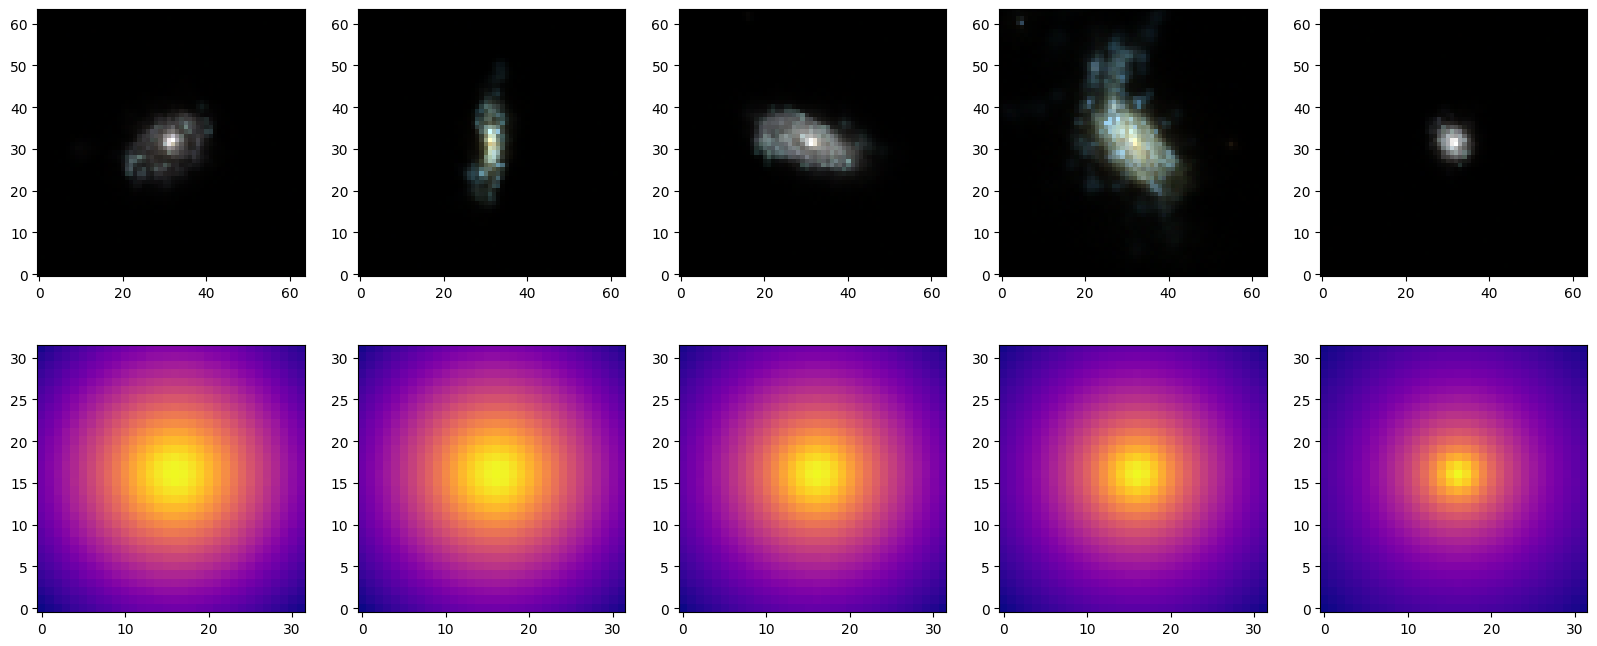

In [ ]:
# Plot samples from the prior
import numpy as np
fig, axarr = plt.subplots(2,5,figsize = (20,8))
for i in range(5):
  print(torch.norm(pG[0] - pG[i]), torch.max(pG[i]))
  axarr[0][i].imshow(np.moveaxis(pG[i].cpu().numpy(),0,2)/np.max(pG[i].cpu().numpy(),axis=(1,2)), origin = "lower") # , cmap="inferno"
  axarr[1][i].imshow(pP[i][0].cpu().numpy(), origin = "lower", cmap="plasma")
plt.show()

## Building the Likelihood

### Construct a forward model

The forward model converts from the "model space" into the "observed space" where we make measurements and where the noise occurs. Diffusion will happen in the model space so that the end result is the desired model. Data and likelihoods exists in observed space. So the forward model is our connection.

In [ ]:
# Make the forward model
def fwd(G, P, upsample = 1):
    roll = P.shape[-1] // 2
    S = next_fast_len(G.shape[-1])
    S = (S, S)
    P = torch.exp(10*(P - P.max())) # the 10x isn't real, it's just to make the PSF easier
    P = P/torch.sum(P, dim=(-2,-1), keepdim=True)
    G_tilde = torch.fft.fft2(G, s=S)
    P_tilde = torch.fft.fft2(P, s=S)
    x_highrez = torch.fft.ifft2(G_tilde * P_tilde, s=S).real
    x_highrez = torch.roll(x_highrez, (-roll, -roll), dims=(-2, -1))[
        ..., : G.shape[-1], : G.shape[-1]
    ]
    # Downsample to observation resolution
    return avg_pool2d(x_highrez[None], upsample).squeeze()

### Create mock data

Here we make a mock observation to try and deconvolve. This is just a sample from our prior, run through the forward model, then with noise added to it.

t = 0.004 | sigma = 0.001 | x = -0.5 ± 2: 100%|██████████| 256/256 [00:23<00:00, 10.84it/s]


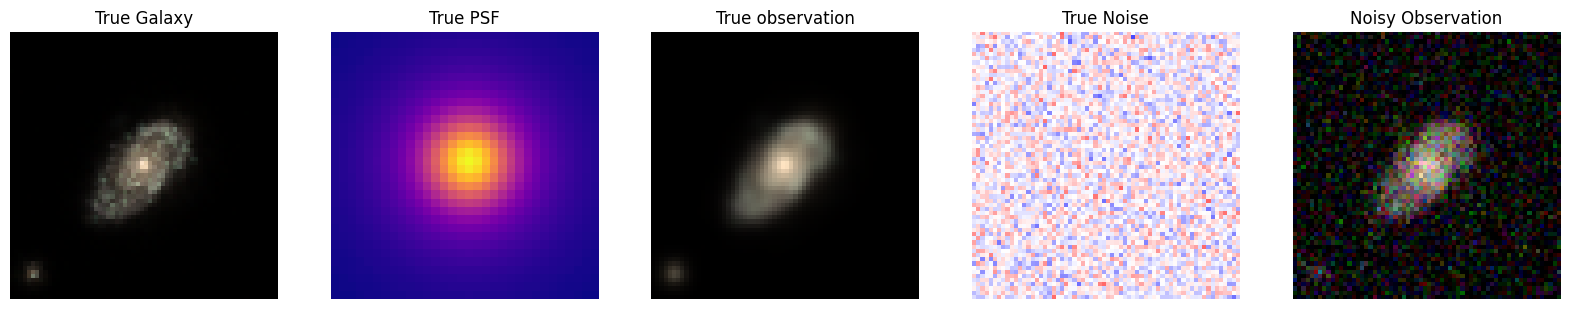

In [ ]:
# Make some data
sample = priormodel.sample(shape = (1, priormodel.model.xsize), N = 256)
trueG, trueP = priormodel.model.split_x(sample)
trueG = trueG.squeeze()
trueP = trueP.squeeze()

trueObs = fwd(trueG, trueP)
sigmanoise = 0.1
trueNoise = torch.randn_like(trueObs) * sigmanoise
var = torch.ones_like(trueObs) * sigmanoise**2
obs = trueObs + trueNoise

fig, axarr = plt.subplots(1,5, figsize=(20,4))
axarr[0].imshow(trueG.movedim(0,2).cpu().numpy(), origin = "lower")
axarr[0].set_title("True Galaxy")

axarr[1].imshow(torch.exp(trueP).cpu().numpy(), origin="lower", cmap="plasma")
axarr[1].set_title("True PSF")

axarr[2].imshow((trueObs.movedim(0,2)/trueObs.max()).cpu().numpy(), origin = "lower")
axarr[2].set_title("True observation")

axarr[3].imshow(trueNoise[0].cpu().numpy(), origin = "lower", cmap="bwr", vmin = -5*sigmanoise, vmax = 5*sigmanoise)
axarr[3].set_title("True Noise")

axarr[4].imshow((obs/obs.max()).movedim(0,2).cpu().numpy(), origin = "lower")
axarr[4].set_title("Noisy Observation")
for ax in axarr:
  ax.axis("off")

plt.show()

### Construct Likelihood score model

This is the model that will encode our experimental setup and compute a score to guide the diffusion. This likelihood score combined with the prior score thus gives us a posterior score.

In [ ]:
# Construct a likelihood
class LikelihoodScoreModel(Module):
    def __init__(
        self,
        sde,
        model,
        obs,
        varmap,
        upsample=1,
    ):
        super().__init__()
        self.sde = sde
        self.model = model
        self.obs = obs
        self.varmap = varmap
        self.upsample = upsample
        self.hyperparameters = {"nn_is_energy": True}


    def tweedie(self, Gt, Pt, t):
        t_scale = self.sde.sigma(t[0])
        t_mu = self.sde.mu(t[0])
        xt = self.model.model.join_x((Gt, Pt))
        s = self.model.score(t, xt)
        x0 = (xt + t_scale**2 * self.model.score(t, xt)) / t_mu
        G0, P0 = self.model.model.split_x(x0)
        return G0, P0

    def log_likelihood(self, t, G, P, obs, var):
        t_scale = self.sde.sigma(t)
        t_mu = self.sde.mu(t)

        # Forward model the galaxy and PSF proposal
        x = fwd(G, P)

        # Compute negative log likelihood
        r = (x - t_mu * obs).reshape(-1)
        return -0.5 * torch.sum(r**2 / ((t_mu**2 * var.reshape(-1) + 0.01*t_scale**2)))

    def log_likelihood_score0(self, t, G0, P0, pass_obs, pass_var):
        return vmap(grad(self.log_likelihood, argnums=(1, 2)))(t, G0, P0, pass_obs, pass_var)

    def log_likelihood_score(self, Gt, Pt, t, pass_obs, pass_var):
        (G0, P0), vjp_func = torch.func.vjp(lambda g, p: self.tweedie(g, p, t), Gt, Pt)
        score0 = self.log_likelihood_score0(t, G0, P0, pass_obs, pass_var)
        return vjp_func(score0)

    def forward(self, t, Gt, Pt, *args, **kwargs):
        # small wrapper to account for input without batch dim from vmap
        pass_obs = self.obs.repeat(Gt.shape[0], 1, 1, 1)
        pass_var = self.varmap.repeat(Gt.shape[0], 1, 1, 1)

        # Make the score function
        scores = self.log_likelihood_score(Gt, Pt, t, pass_obs, pass_var)
        return scores

likelihood = LikelihoodScoreModel(
    sde=sde,
    model=priormodel,
    obs=obs,
    varmap=var,
)
likelihood.to(device=DEVICE)
# likelihoodmodel = ScoreModel(model=likelihood, sde=sde)

LikelihoodScoreModel(
  (model): ScoreModel(
    (model): JointScoreModel()
  )
)

## Building a Posterior model

### Joint Prior and Likelihood

With the Prior model and the Likelihood model already constructed above, it is trivial to make a score model which is simply the sum of the two.

In [ ]:
# Build a joint posterior model
posteriormodel = ScoreModel(
    model=JointScoreModel(
        sde=sde,
        models=[priormodel, likelihood],
        x_shapes=[galshape, psfshape],
        model_uses=[None, (0,1)],
    ),
    sde=sde,
)
posteriormodel.to(device=DEVICE)

# Draw samples
posteriorsamples = posteriormodel.sample(
    shape = (5, priormodel.model.xsize),
    N = 1024,
    # corrector=True,
    # corrector_steps=1,
    # corrector_snr=0.1,
)
Gp, Pp = priormodel.model.split_x(posteriorsamples)

t = 0.001 | sigma = 0.001 | x = -0.5 ± 2: 100%|██████████| 1024/1024 [05:02<00:00,  3.38it/s]


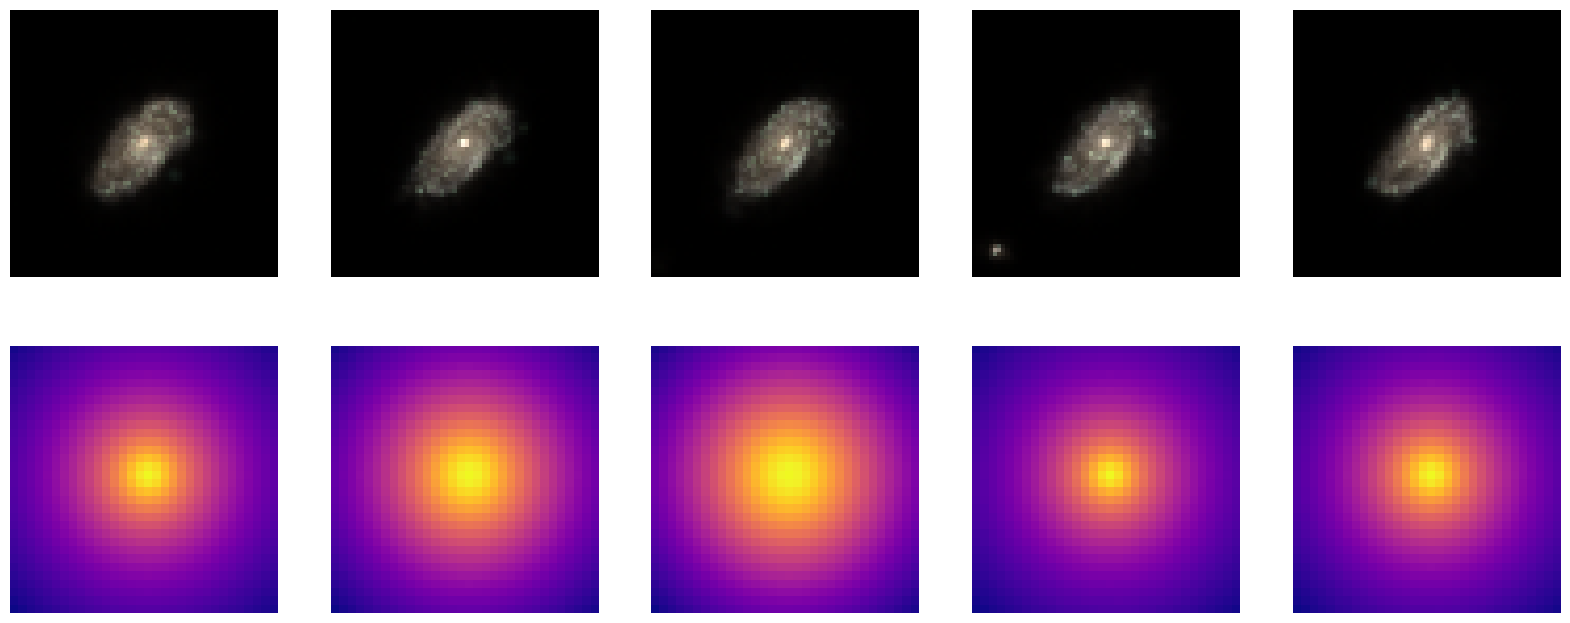

In [ ]:
# Plot samples from the posterior
fig, axarr = plt.subplots(2,5,figsize = (20,8))
for i in range(5):
  axarr[0][i].imshow(Gp[i].moveaxis(0,2).cpu().numpy(), origin = "lower")
  axarr[1][i].imshow(Pp[i][0].cpu().numpy(), origin = "lower", cmap="plasma")
  axarr[0][i].axis("off")
  axarr[1][i].axis("off")
plt.show()